# Classifying Fashion-MNIST

직접 neural network를 정의하고 훈련하여 image 분류기를 만들어 보자.  
[Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist)을 사용한다. 이 데이터 셋은 28x28 크기의 greyscale images로 각종 의류에 대한 이미지 데이터 셋이다. 이 데이터 셋은 앞서 본 MNIST 보다는 좀 더 복잡한 패턴을 가지고 있다.
![img](../assets/fashion-mnist-sprite.png)

이 실습을 통해 각자의 neural network로 이미지 분류기를 생성한다. 앞에서 본 MNIST 분류기의 코드를 참조하여 구현할 수 있을 것이다.  

일단 필요한 패키지를 import하는 것 부터 시작해 보자.

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data.dataset import random_split
%matplotlib inline

torchvision의 datasets를 통해 FasionMNIST 데이터 셋을 다운로드하고 DataLoader로 데이터를 읽어 들인다.  
- 총 10개의 class로 되어 있다.  
- class : ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

In [2]:
# Define a transform to normalize the data
transform = transforms.ToTensor()

# Download and load the training data
trainset = datasets.FashionMNIST('../data', download=True, train=True, transform=transform)
trainset, validset = random_split(trainset, [40000, 20000])

# Download and load the test data
testset = datasets.FashionMNIST('../data', download=True, train=False, transform=transform)

C:\Users\aoneko\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

불러들인 이미지 데이터를 화면에 출력하여 제대로 읽어 들여졌는지 확인해 보자.

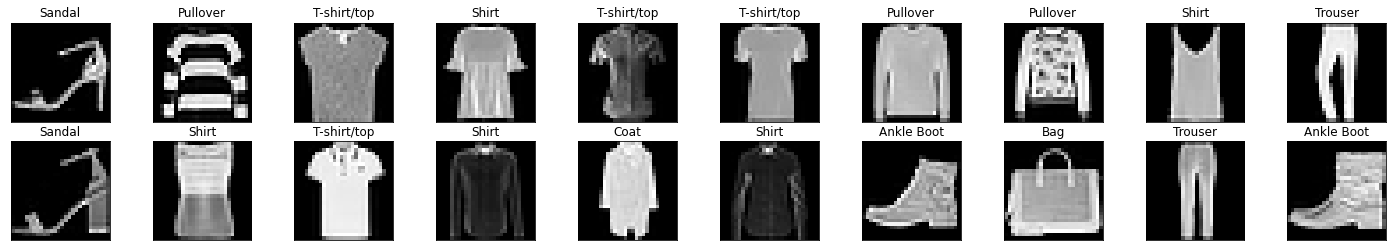

In [4]:
images, labels = next(iter(trainloader))
images = images.numpy()

class_name = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(class_name[labels[idx].item()])

## Building the network

각자만의 모형을 구현해 보자. MNIT 이미지 분류기와 유사하게 28x28 크기로 총 784 pixels의 이미지이다. 총 10개의 class로 되어 있다.  
`class : ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']`

hidden layer의 갯수, hidden unit의 갯수, drop out의 사용여부, loss function, optimizer 등과 관련된 여러가지 설정은 개인의 판단에 따라 적절히 선택하도록 한다.

In [5]:
from torch import nn, optim
import torch.nn.functional as F

In [6]:
# TODO: Define your network architecture here
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 10)
        #self.dropout = nn.Dropout(0.3)
               
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = F.relu(self.fc3(x))
        #x = self.dropout(x)
        x = self.fc4(x)
        
        return x

# Train the network

먼저 loss 함수와 optimizer를 설정한다. [criterion](http://pytorch.org/docs/master/nn.html#loss-functions)은 `nn.CrossEntropyLoss` 또는 `nn.NLLLoss`로 설정할 수 있다. 또한 [optimizer](http://pytorch.org/docs/master/optim.html) 는 `optim.SGD` 또는 `optim.Adam`로 설정 가능 하다.

모형을 훈련하기 위해 다음과 같은 사항을 고려한다:

* forward pass를 수행한다.
* loss를 계산한다.
* `loss.backward()` 로 backward pass를 수행하고 gradients를 계산한다.
* optimizer의 step으로 weights를 업데이트한다.

hidden units, learning rate... 등은 hyper parameter로 각자 알맞은 값으로 설정한다.

In [7]:
# TODO: Create the network, define the criterion and optimizer
model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [8]:
model

Classifier(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=10, bias=True)
)

In [9]:
# TODO: Train the network here
epochs = 15
print("Training the model..........")

train_losses = []
valid_losses = []

for e in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for images, labels in trainloader:
        out = model(images)
        loss = criterion(out, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)

    model.eval() # prep model for evaluation
    for data, target in validloader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(validloader.dataset)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print('#{} Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(e+1, train_loss, valid_loss))

Training the model..........
#1 Training Loss: 0.534910 	Validation Loss: 0.436174
#2 Training Loss: 0.390644 	Validation Loss: 0.394470
#3 Training Loss: 0.353108 	Validation Loss: 0.371417
#4 Training Loss: 0.320752 	Validation Loss: 0.351955
#5 Training Loss: 0.304899 	Validation Loss: 0.337537
#6 Training Loss: 0.288072 	Validation Loss: 0.331169
#7 Training Loss: 0.268541 	Validation Loss: 0.331625
#8 Training Loss: 0.259298 	Validation Loss: 0.332770
#9 Training Loss: 0.247518 	Validation Loss: 0.317813
#10 Training Loss: 0.234658 	Validation Loss: 0.339126
#11 Training Loss: 0.226171 	Validation Loss: 0.330092
#12 Training Loss: 0.215693 	Validation Loss: 0.330413
#13 Training Loss: 0.208814 	Validation Loss: 0.345423
#14 Training Loss: 0.202142 	Validation Loss: 0.337112
#15 Training Loss: 0.192346 	Validation Loss: 0.350715


### 훈련결과 

train loss와 validation loss 시각화

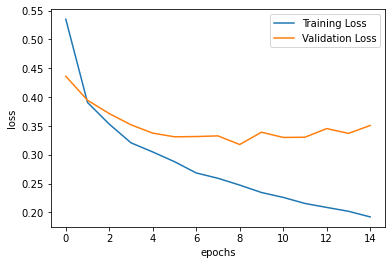

In [10]:
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

## Test the Trained Networks
test data set으로 훈련된 모형을 평가한다. test loss와 accuracy를 확인해 본다.

In [11]:
corrects = 0
test_loss = 0

model.eval()

for images, labels in testloader:
    outputs = model(images)
    loss = criterion(outputs, labels)
    test_loss += loss.item()*images.size(0)
    
    _, preds = torch.max(outputs, 1)
    
    corrects += torch.sum(preds == labels.data)
    
test_loss = test_loss/len(testloader.dataset)
acc = corrects.double()/len(testloader.dataset)

print("Test Loss : {:.4f}, Accuracy : {:.4f}".format(test_loss, acc))
    

Test Loss : 0.3882, Accuracy : 0.8824


## Model Prediction

훈련된 모형에 대해 test데이터를 활용하여 이미지를 분류해 보고 결과를 시각화한다.

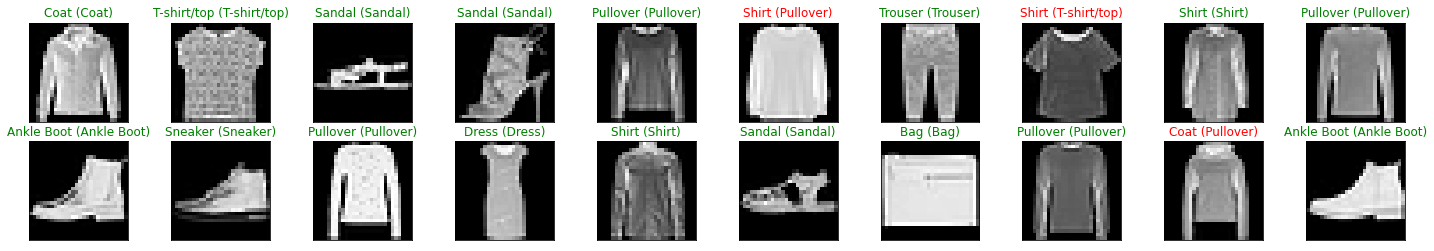

In [12]:
model.eval()

images, labels = next(iter(testloader))

output = model(images)

ps, preds = torch.max(output, 1)

images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(class_name[preds[idx].item()], class_name[labels[idx].item()]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# 실습 

1. 모형에 dropout을 추가해 보시오.
2. 모형의 정확도를 향상 시켜 보시오. 모형의 성능 향상을 위해 hyperparameter를 튜닝해 보시오.
    * hidden layer, hidden unit
    * learning_rate
    * optimizer 종류
    * batch_size
    * epoch